In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [5]:
x = [1, 2, 3, 4, 2,1,3 ,1,1,1,1,1,1]

9


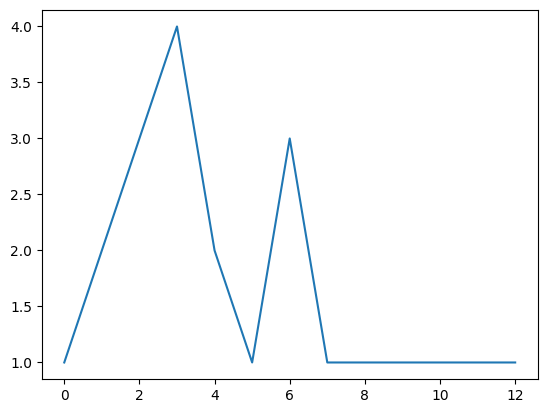

In [13]:
for i in range(10):
    clear_output()
    time.sleep(1)
    print(i)
    plt.plot(x)
    plt.show()

In [2]:
from typing import Dict
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torchio as tio

from ml.models.ResUnet import ResUNet
from ml.models.unet_deepsup import Unet_MSS

from ml.models.building_blocks import VG_discriminator
from ml.extra_libraries.CycleGAN_losses import (CycleLoss, ReconstructionLoss, SegmentationLoss,
                                       DiscriminatorLoss, GeneratorLoss)
from ml.losses import IOU_Metric

In [10]:
from ml.tio_dataset import TioDataset
train_settings  = {
    "patch_shape" : (64, 64, 32),
    "patches_per_volume" : 32,
    "patches_queue_length" : 512,
    "batch_size" : 5,
    "num_workers": 4,
    "sampler": "weighted" #"uniform",#
}

# val_settings  = {
#     "patch_shape" : (32, 32, 32),
#     "patches_per_volume" : 32,
#     "patches_queue_length" : 1440,
#     "batch_size" : 8,
#     "num_workers": 4,
#     "sampler": "uniform",#"weighted" #"uniform",#
# }

test_settings  = {
    "patch_shape" : (192, 192, 128),
    "overlap_shape" : (24, 24, 16),
    "batch_size" : 1,
    "num_workers": 4,
}

data_dir = "/home/msst/Documents/medtech/MainData"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=None,
                 test_settings=test_settings)

In [4]:
class VanGan(nn.Module):
    def __init__(self, modules):
        super(VanGan, self).__init__()
        self.gen_IS = modules['gen_IS']
        self.gen_SI = modules['gen_SI']
        self.disc_I = modules['disc_I']
        self.disc_S = modules['disc_S']

In [5]:
modules = {
    #'gen_IS': ResUNet(channels_coef=8),
    #'gen_SI': ResUNet(channels_coef=8),
    'gen_IS': Unet_MSS(channels_coef=16),
    'gen_SI': Unet_MSS(channels_coef=16),
    'disc_I': VG_discriminator(channels_coef=64),
    'disc_S': VG_discriminator(channels_coef=64),
}
model = VanGan(modules)

In [6]:
class VG_Controller:
    def __init__(self, config: Dict):
        self.config = config
        self.device = config['device']
        self.model = config["model"]
        
        otimizers_settings = config["otimizers_settings"]
        self.gen_IS_opt = otimizers_settings['gen_IS_opt'](self.model.gen_IS)
        self.gen_SI_opt = otimizers_settings['gen_SI_opt'](self.model.gen_SI)
        self.disc_I_opt = otimizers_settings['disc_I_opt'](self.model.disc_I)
        self.disc_S_opt = otimizers_settings['disc_S_opt'](self.model.disc_S)
        
        if config.get('sheduler_fn') is not None:
            self.with_sheduler = True
            self.gen_IS_sheduler = otimizers_settings['sheduler_fn'](self.gen_IS_opt)
            self.gen_SI_sheduler = otimizers_settings['sheduler_fn'](self.gen_SI_opt)
            self.disc_I_sheduler = otimizers_settings['sheduler_fn'](self.disc_I_opt)
            self.disc_S_sheduler = otimizers_settings['sheduler_fn'](self.disc_S_opt)
        else:
            self.with_sheduler = False
        
        losses = config["losses"]
        self.cycle_loss_fn = losses["cycle_loss_fn"]
        self.reconstruction_loss_fn = losses["reconstruction_loss_fn"]
        self.segmentation_loss_fn = losses["segmentation_loss_fn"]
        self.discriminator_loss_fn = losses["discriminator_loss_fn"]
        self.generator_loss_fn = losses["generator_loss_fn"]
        self.cycle_lambda = losses["cycle_lambda"]
        self.identity_lambda = losses["identity_lambda"]
        
        self.epoch = 0
        self.history = None
        
        self.metric_fn = IOU_Metric()
        
        

    def fit(self, dataset, n_epochs):
        model = self.model.to(self.device)
        if self.history is None:
            self.history = {
                'train': [],
                'val': [],
                "test": [],
            }
        
        start_epoch = self.epoch
        for epoch in range(start_epoch, start_epoch+n_epochs):
            self.epoch += 1
            print(f"Epoch {epoch + 1}/{start_epoch+n_epochs}")
            
            train_info = self.train_epoch(dataset.train_dataloader)
            print(train_info)
            self.history['train'].append(train_info)
            
            if dataset.test_dataloader is not None:
                test_info = self.test_epoch(dataset.test_dataloader)
                print(test_info)
                self.history['test'].append(test_info)
            
            if self.with_sheduler:
                self.gen_IS_sheduler.step()
                self.gen_SI_sheduler.step()
                self.disc_I_sheduler.step()
                self.disc_S_sheduler.step()
            
        return self.model.eval()

    
    def train_epoch(self, train_dataloader):
        self.model.train()
        
        gen_IS_losses = []
        gen_SI_losses = []
        disc_I_losses = []
        disc_S_losses = []
        segmentation_losses = []
        reconstruction_losses = []
        
        for patches_batch in tqdm(train_dataloader):
            real_I = patches_batch['head']['data'].float().to(self.device)  
            real_S = patches_batch['vessels']['data'].float().to(self.device) 
            
            #Generator outputs
            fake_S = self.model.gen_IS(real_I)
            fake_I = self.model.gen_SI(real_S)
            cycled_S = self.model.gen_IS(fake_I)
            cycled_I = self.model.gen_SI(fake_S)

            # Discriminator outputs         
            disc_real_S = self.model.disc_S(real_S)
            disc_fake_S = self.model.disc_S(fake_S)
            disc_real_I = self.model.disc_I(real_I)
            disc_fake_I = self.model.disc_I(fake_I)
            
            #Losses
            cycle_loss_I = self.cycle_loss_fn(real_S, cycled_S)
            cycle_loss_S = self.cycle_loss_fn(real_I, cycled_I)
            
            segmentation_loss = self.segmentation_loss_fn(real_S, cycled_S)
            reconstruction_loss = self.reconstruction_loss_fn(real_I, cycled_I)

            gen_IS_loss = self.generator_loss_fn(disc_fake_S)
            gen_SI_loss = self.generator_loss_fn(disc_fake_I)

            total_loss_I = gen_IS_loss + self.cycle_lambda * cycle_loss_I +\
                           self.identity_lambda * segmentation_loss
            total_loss_S = gen_SI_loss + self.cycle_lambda * cycle_loss_S +\
                           self.identity_lambda * reconstruction_loss  # + id_IS_loss
            
            
            # -----------------
            # Generators
            # -----------------
            self.gen_IS_opt.zero_grad()
            self.gen_SI_opt.zero_grad()
            
            total_loss_I.backward(retain_graph=True)
            total_loss_S.backward(retain_graph=True)
            
            self.gen_IS_opt.step()
            self.gen_SI_opt.step()
            
            # -----------------
            # Discriminators
            # -----------------
            
            self.disc_I_opt.zero_grad()
            self.disc_S_opt.zero_grad()
            
            disc_I_loss = self.discriminator_loss_fn(disc_real_I, disc_fake_I)
            disc_S_loss = self.discriminator_loss_fn(disc_real_S, disc_fake_S)
            
            disc_I_loss.backward(retain_graph=True)
            disc_S_loss.backward()
            
            self.disc_I_opt.step()
            self.disc_S_opt.step()
            
            gen_IS_losses.append(gen_IS_loss.item())
            gen_SI_losses.append(gen_SI_loss.item())
            disc_I_losses.append(disc_I_loss.item())
            disc_S_losses.append(disc_S_loss.item())
            segmentation_losses.append(segmentation_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
        
        self.model.eval()
        out = {'gen_IS_loss': sum(gen_IS_losses)/len(gen_IS_losses),
                'gen_SI_loss': sum(gen_SI_losses)/len(gen_SI_losses),
                'disc_I_loss': sum(disc_I_losses)/len(disc_I_losses),
                'disc_S_loss': sum(disc_S_losses)/len(disc_S_losses),
                'segmentation_loss': sum(segmentation_losses)/len(segmentation_losses),
                'reconstruction_loss': sum(reconstruction_losses)/len(reconstruction_losses),
               }
        return out
    
    
    def test_epoch(self, test_dataloader):
        self.model.eval()
        metrics = []
        for batch in tqdm(test_dataloader):
            patch_loader = batch["patch_loader"]
            grid_aggregator = batch["grid_aggregator"]
            GT = batch["GT"]
            sample_name = batch["sample_name"]
            head_seg = self.fast_predict(patch_loader, grid_aggregator)
            metric = self.metric_fn(GT.data, head_seg)
            metrics.append({"sample" : sample_name,
                            "seg_sum/GT_sum" : head_seg.sum()/GT.data.sum()+0.000001,
                            "metric1" : metric})
            
        return {'metrics': metrics}
    
    def fast_predict(self, patch_loader, grid_aggregator, thresh=0.5):
        for patches_batch in patch_loader:
            patch_locations = patches_batch[tio.LOCATION]
            head_patches = patches_batch['head']['data'].to(self.device)
            with torch.no_grad():
                patch_seg = self.model.gen_IS(head_patches)
                grid_aggregator.add_batch(patch_seg.cpu(), patch_locations)
        seg = grid_aggregator.get_output_tensor()
        seg[seg<thresh]=0
        seg[seg>0]=1
        return(seg)
    

In [7]:
config = {"device": "cuda",
          "otimizers_settings":{
            "gen_IS_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.5, 0.9)),
            "gen_SI_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.5, 0.9)),
            "disc_I_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.5, 0.9)),
            "disc_S_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.5, 0.9)),
            "sheduler_fn": lambda optimizer: ExponentialLR(optimizer, 0.9)
            },
          "model": model,
          "losses":{
            "cycle_loss_fn": CycleLoss(),
            "reconstruction_loss_fn": ReconstructionLoss(),
            "segmentation_loss_fn": SegmentationLoss(),
            "discriminator_loss_fn": DiscriminatorLoss(),
            "generator_loss_fn": GeneratorLoss(),
            "cycle_lambda" : 10, 
            "identity_lambda" : 5,
            }
          }
vg_controller = VG_Controller(config)

In [11]:
vg_controller.fit(dataset, 50)

Epoch 2/51


100%|███████████████████████████████████████████| 26/26 [00:36<00:00,  1.39s/it]


{'gen_IS_loss': 0.7188867880747869, 'gen_SI_loss': 0.9999962265674884, 'disc_I_loss': 0.49999918043613434, 'disc_S_loss': 0.254559718645536, 'segmentation_loss': 0.33604933665348935, 'reconstruction_loss': 0.12829128222969863}


100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.01s/it]


{'metrics': [{'sample': 'P62_CTA_0', 'seg_sum/GT_sum': tensor(0.0008), 'metric1': tensor([3.3484e-11])}, {'sample': 'new_CTA_0', 'seg_sum/GT_sum': tensor(3.1494e-05), 'metric1': tensor([3.3881e-11])}]}
Epoch 3/51


100%|███████████████████████████████████████████| 26/26 [00:38<00:00,  1.47s/it]


{'gen_IS_loss': 0.7219376185765634, 'gen_SI_loss': 0.9999909194616171, 'disc_I_loss': 0.49999859585211825, 'disc_S_loss': 0.2951166538091806, 'segmentation_loss': 0.4530435364979964, 'reconstruction_loss': 0.0974854664483036}


100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.04s/it]


{'metrics': [{'sample': 'P62_CTA_0', 'seg_sum/GT_sum': tensor(6.9845), 'metric1': tensor([0.0105])}, {'sample': 'new_CTA_0', 'seg_sum/GT_sum': tensor(0.6594), 'metric1': tensor([0.0926])}]}
Epoch 4/51


100%|███████████████████████████████████████████| 26/26 [00:38<00:00,  1.48s/it]


{'gen_IS_loss': 0.5049440352102885, 'gen_SI_loss': 0.627838589824163, 'disc_I_loss': 0.48861043269817644, 'disc_S_loss': 0.314293683721469, 'segmentation_loss': 0.19164161957227266, 'reconstruction_loss': 0.14039665833115578}


100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.01s/it]


{'metrics': [{'sample': 'P62_CTA_0', 'seg_sum/GT_sum': tensor(0.0501), 'metric1': tensor([3.1912e-06])}, {'sample': 'new_CTA_0', 'seg_sum/GT_sum': tensor(0.0024), 'metric1': tensor([4.0561e-05])}]}
Epoch 5/51


100%|███████████████████████████████████████████| 26/26 [00:38<00:00,  1.48s/it]


{'gen_IS_loss': 0.7538539469242096, 'gen_SI_loss': 0.5789563621465976, 'disc_I_loss': 0.4556983938583961, 'disc_S_loss': 0.22306309081614017, 'segmentation_loss': 0.6915452342766982, 'reconstruction_loss': 0.22530006230450594}


100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.06s/it]


{'metrics': [{'sample': 'P62_CTA_0', 'seg_sum/GT_sum': tensor(2.6694), 'metric1': tensor([7.3059e-06])}, {'sample': 'new_CTA_0', 'seg_sum/GT_sum': tensor(0.0224), 'metric1': tensor([4.3084e-05])}]}
Epoch 6/51


100%|███████████████████████████████████████████| 26/26 [00:38<00:00,  1.49s/it]


{'gen_IS_loss': 0.6208614151065166, 'gen_SI_loss': 0.28408230760340725, 'disc_I_loss': 0.46075764527687657, 'disc_S_loss': 0.21335595101118088, 'segmentation_loss': 0.27112147212028503, 'reconstruction_loss': 0.1702665124231806}


100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.14s/it]


{'metrics': [{'sample': 'P62_CTA_0', 'seg_sum/GT_sum': tensor(0.0414), 'metric1': tensor([3.2177e-11])}, {'sample': 'new_CTA_0', 'seg_sum/GT_sum': tensor(0.0007), 'metric1': tensor([1.0157e-05])}]}
Epoch 7/51


 27%|███████████▊                                | 7/26 [00:14<00:39,  2.09s/it]


KeyboardInterrupt: 